In [67]:
# imports
import pandas as pd
import geonamescache
import unidecode 
from IPython.display import display

In [2]:
# Read the original data
headlines = pd.read_csv('data/headlines.txt', sep='\t',header=None)
headlines.columns = ['headlines']

headlines.sample(10)

,headlines
104,Petaling Jaya man ill from Zika
262,Authorities are Worried about the Spread of Go...
20,Chicago's First Zika Case Confirmed
485,Barcelona Struck by Spanish Flu
142,Authorities are Worried about the Spread of Tu...
624,Hepatitis C Outbreak in Bethlehem
479,"Sulu, Zamboanga brace for Zika"
492,Rumors about Chlamydia spreading in Redmond ha...
319,Authorities are Worried about the Spread of Ch...
304,Pneumonia Symptoms Spread all over Bloomington


In [10]:
# Init an instance
gc = geonamescache.GeonamesCache()

def find_city(text):
    """
    Parameters
    ----------
    text : str
        A text string, potentially containing cities.

    Returns
    -------
    city : str
        The largest city in the text.
    lat : float
        The latitude of `city`.
    lon : float
        The longitude of `city`.
    geonameid : int
        The geonameid of `city`.
    """
    cities = []
    for city in gc.get_cities().values():
        if city['name'] in text:
            cities.append(city)
    if len(cities) == 0:
        return None
    cities.sort(key=lambda x: x['population'], reverse=True)
    return cities[0]['name'], cities[0]['latitude'], cities[0]['longitude'], cities[0]['countrycode']


# Create the columns
headlines['temp'] = headlines['headlines'].apply(find_city)
headlines['city'] = headlines['temp'].apply(lambda x: x[0] if x is not None else None)
headlines['lat'] = headlines['temp'].apply(lambda x: x[1] if x is not None else None)
headlines['lon'] = headlines['temp'].apply(lambda x: x[2] if x is not None else None)
headlines['code'] = headlines['temp'].apply(lambda x: x[3] if x is not None else None)
headlines.drop(['temp'], axis=1, inplace=True)

# Print a sample
headlines.head(5)

,headlines,city,lat,lon,code
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami,25.77427,-80.19366,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US


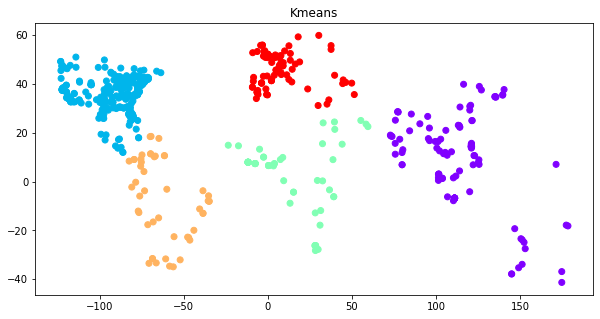

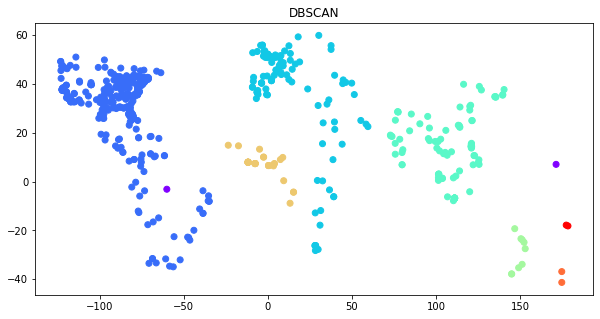

In [89]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import folium
from folium import plugins
from folium.plugins import HeatMap

# Kmeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(headlines[['lat', 'lon']])

# DBSCAN
dbscan = DBSCAN(eps=12, min_samples=2)
dbscan.fit(headlines[['lat', 'lon']])

# Plot
plt.figure(figsize=(10,5))
plt.scatter(headlines['lon'], headlines['lat'], c=kmeans.labels_, cmap='rainbow')
plt.title('Kmeans')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(headlines['lon'], headlines['lat'], c=dbscan.labels_, cmap='rainbow')
plt.title('DBSCAN')
plt.show()

# Plot on world map
m = folium.Map([0, 0], zoom_start=2)

for index, row in headlines[['lat', 'lon']].iterrows():
    folium.CircleMarker([row['lat'], row['lon']],
                        radius=3,
                        weight=2,
                        color='red',
                        fill_color='red',
                        fill_opacity=.5).add_to(m)

m.save('map_clusters.html')
display(m)
# Heatmap
m = folium.Map([0, 0], zoom_start=2)

HeatMap(headlines[['lat', 'lon']]).add_to(m)

m.save('map_heatmap.html')
display(m)

In [81]:
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

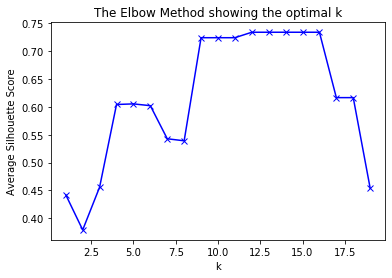

The optimal k is: 12
The average silhouette score is: 0.7337054099144596


In [86]:
def elbow_method(X, max_k):
    """
    :param X: ndarray
    :param max_k: int
    :return: int, int
    """
    # get the distances of the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    # get the best k
    k = range(1, max_k)
    avg_silhouette_scores = []
    for i in k:
        db = DBSCAN(eps=i, min_samples=2).fit(X)
        labels = db.labels_
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        avg_silhouette_scores.append(metrics.silhouette_score(X, labels))
    plt.plot(k, avg_silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    return k[np.argmax(avg_silhouette_scores)], np.max(avg_silhouette_scores)


k, avg_silhouette_score = elbow_method(headlines[['lon', 'lon']], 20)
print("The optimal k is: {}".format(k))
print("The average silhouette score is: {}".format(avg_silhouette_score))